<center>
   
## [Acoustic Metamaterial Generative Design and Optimisation Pipeline](https://github.com/frantic0/ammgdop)

Author: [Francisco Bernardo](https://fbernardo.com). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

This notebook implements basic data analysis and the required post-processing operations for extracting measurements from the acoustic pressure field obtained from the Helmholtz solver. Metrics include:

* Transmission Loss
* Acoustic Velocity
* Peak Acoustic Pressure (TBC)

To set up the notebook with the required dependencies make sure you have them installed in the system, before you load the notebook. Use your package manager such as conda or pip to install then, for instance:

> $ pip3 install numpy

> $ pip3 install pandas

> $ pip3 install matplotlib


In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os

# Boundary Conditions
inletBC = 1
outletBC = 3

rho0 = 1.205
c0 = 343
flowDir = np.array([1, 0, 0]);

# pd.set_option("display.precision", 2)

To start analysing the labyrinthine bricks let's define a function to read the data using `parseDatNames`

In [9]:
def parseDatNames(filename):
    res = [] # Initialize
    if filename[-6:] != ".names":
        filename = filename + ".names"
    with open(filename, 'r') as f:
        isHeader = True
        for line in f:
            if 'Variables in columns' in line:
                isHeader = False
                continue
            if isHeader == True:
                continue

            # strParse1: get rid of 1: boundary mean, and split over "over"
            strParse1 = line.strip().split(':')[-1].strip().split('over')
            if len(strParse1) == 1:
                res.append(strParse1[0])
            else:
                if len(strParse1[0]) > 0:
                    itemName = strParse1[0]
                else:
                    strParse1[0] = itemName
                res.append(strParse1[0].strip() + '.' + strParse1[1].strip())
    return res

Let's take a look at the files and column names exported by Elmer:

In [12]:
# filename = './data/brick-15/SPLmean.dat'
# filenames[i] = '../ammgdop-ds-20220208/brick-15/SPLmean.dat'

datFileName = lambda a: '../ammgdop-ds-20220208/brick-{}/SPLmean.dat'.format(a)

datFileNames = [ datFileName(fn) for fn in range(1,16) ]

# Parse input names, this list is shared across all bricks 
column_names = parseDatNames(datFileNames[14])

print('#files: {}'.format(len(datFileNames)), *datFileNames, sep='\n')


#files: 15
../ammgdop-ds-20220208/brick-1/SPLmean.dat
../ammgdop-ds-20220208/brick-2/SPLmean.dat
../ammgdop-ds-20220208/brick-3/SPLmean.dat
../ammgdop-ds-20220208/brick-4/SPLmean.dat
../ammgdop-ds-20220208/brick-5/SPLmean.dat
../ammgdop-ds-20220208/brick-6/SPLmean.dat
../ammgdop-ds-20220208/brick-7/SPLmean.dat
../ammgdop-ds-20220208/brick-8/SPLmean.dat
../ammgdop-ds-20220208/brick-9/SPLmean.dat
../ammgdop-ds-20220208/brick-10/SPLmean.dat
../ammgdop-ds-20220208/brick-11/SPLmean.dat
../ammgdop-ds-20220208/brick-12/SPLmean.dat
../ammgdop-ds-20220208/brick-13/SPLmean.dat
../ammgdop-ds-20220208/brick-14/SPLmean.dat
../ammgdop-ds-20220208/brick-15/SPLmean.dat


Let’s have a look at data dimensionality, feature names, and feature types.

In [13]:
readlinesToArray = lambda f: np.array([ np.fromstring(line.strip(), dtype=float, sep=' ') for line in f ])

def readDatFile(n):     
    with open(datFileNames[n], 'r') as f:
        return [ np.fromstring(line.strip(), dtype=float, sep=' ') for line in f ]
    
    
temp = [] 
for i in range(0,15):
    temp.append(readDatFile(i))
    
print(len(temp), *temp, '\n')



15 [array([ 9.99996690e-01, -2.04699860e-01, -8.67595045e-34, -3.68314948e-01,
        1.37179422e+00,  1.72685629e+01, -2.93770706e-01,  3.45786948e+01,
       -1.28569483e+00,  6.03621566e-01,  7.28798392e-01,  2.22970480e+00,
        2.24325232e+02,  1.75330815e+02,  3.42918833e+02,  8.77071829e+01,
        4.00000000e+04]), array([ 9.99996690e-01, -2.64216428e-01, -5.19606126e-36, -3.29197849e-01,
        1.61474502e+00,  5.00510067e+01, -4.93308145e-01,  3.90635179e+01,
       -1.04173847e+00,  4.13063727e-01,  5.05169774e-01,  1.64262319e+00,
        3.09681627e+02,  2.00141662e+02,  2.78245944e+02,  1.47859600e+02,
        4.05000000e+04]), array([ 9.99996690e-01, -2.44962549e-01,  1.87362266e-33, -1.08401949e-01,
        1.41626070e+00,  1.05499716e+02, -1.53577560e+00, -7.15043325e+01,
       -1.36703279e+00,  3.34425513e-01, -9.11567516e-01,  2.02257370e+00,
        2.03312374e+02,  4.35886708e+02,  2.66727674e+01,  1.78661838e+02,
        4.10000000e+04])] [array([ 9.9999669

Let's now get the frequency and pressure values and assign to variables


To calculate velocity at inlet, we use **uIn = 1j / rho0 / omegaVec * dp/dn**

To decompose the p to p+ and p-, we consider 

**p+ + p- = p** and **p+ - p- = uIn * rho0 * c0**

so, 

**p+ = (p + uIn * rho0 * c0) / 2**



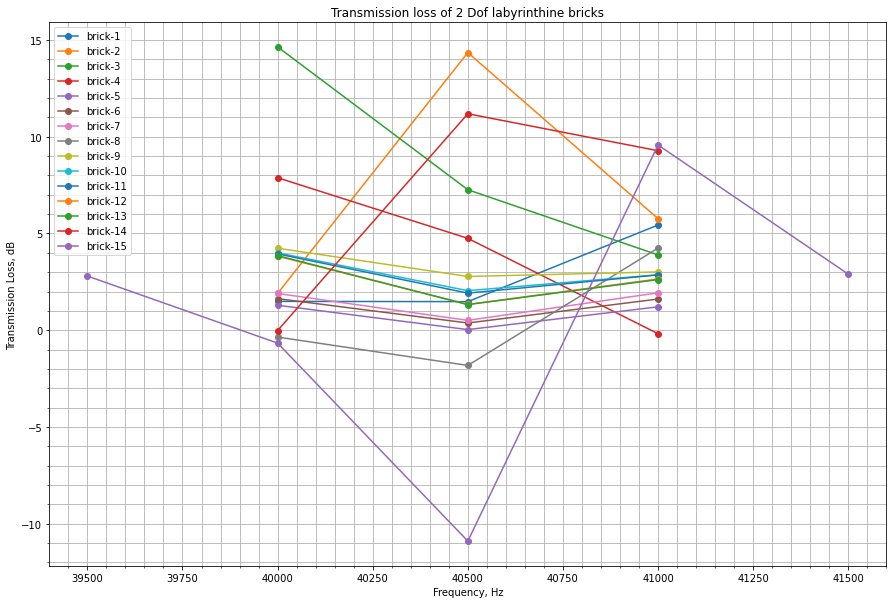

In [15]:
def calculateTransmissionLoss(res, frequency_column_index, flowDir):

#     frequency_columns_index = column_names.index('frequency')
    freqVec = res[:, frequency_column_index]
    omegaVec = 2 * np.pi * freqVec

    ## Get pressure at inlet and outlet

    pIn = res[:, column_names.index('pressure wave 1.bc ' + str(inletBC))] \
     + 1j * res[:, column_names.index('pressure wave 2.bc ' + str(inletBC))]

    pOut = res[:, column_names.index('pressure wave 1.bc ' + str(outletBC))] \
     + 1j * res[:, column_names.index('pressure wave 2.bc ' + str(outletBC))]

    # print(pIn)
    # print(pOut)

    #  Check if it is 3D
    dim = 3
    if "pressure wave 1 grad 3.bc 1" not in column_names:
        dim = 2
        flowDir = flowDir[:-1]

    pGradIn, pGradOut = np.zeros((freqVec.size, dim), dtype=np.complex_), np.zeros((freqVec.size, dim), dtype=np.complex_)

    # Get pGradIn and pGradOut
    fmt = 'pressure wave {0:d} grad {1:d}.bc {2:s}'
    for ind in range(dim):
        # Inlet
        strReal = fmt.format(1, ind+1, str(inletBC))
        strImag = fmt.format(2, ind+1, str(inletBC))
        pGradIn[:, ind] = res[:, column_names.index(strReal)] + 1j * res[:, column_names.index(strImag)]
        # outlet
        strReal = fmt.format(1, ind+1, str(outletBC))
        strImag = fmt.format(2, ind+1, str(outletBC))
        pGradOut[:, ind] = res[:, column_names.index(strReal)] + 1j * res[:, column_names.index(strImag)]

    # Decomposition at inlet
    dpdnIn = pGradIn.dot(flowDir)
    uIn = 1j/rho0/omegaVec*dpdnIn
    pInPlus = (pIn + uIn*rho0*c0)/2
    pInMinus = pIn - pInPlus

    # Decomposition at outlet
    dpdnOut = pGradOut.dot(flowDir)
    uOut = 1j/rho0/omegaVec*dpdnOut

    # Transmission Loss
    TL = 20*np.log10(np.abs(pInPlus)/np.abs(pOut))
    
    return freqVec, TL



# Plot
plt.close("all")
plt.rcParams["figure.figsize"] = (15,10)

fig, ax = plt.subplots()
ax.minorticks_on()
ax.grid(which='both')

for i in range(0,15):
    freqVec, TL = calculateTransmissionLoss(np.array(temp[i]), column_names.index('frequency'), flowDir)
    ln = plt.plot(freqVec, TL, '-o', label='brick-{}'.format(i+1))
    plt.legend(loc='best')

plt.xlabel('Frequency, Hz')
plt.ylabel('Transmission Loss, dB')
plt.title("Transmission loss of 2 Dof labyrinthine bricks")
plt.show()



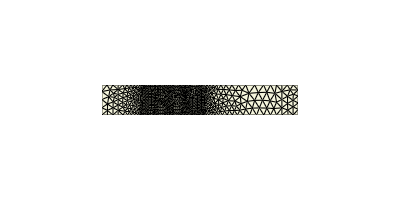

In [16]:
import vtk
from IPython.display import Image

def vtk_show(renderer, w=100, h=100):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.SetLineSmoothing(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(w, h)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = memoryview(writer.GetResult()).tobytes()
    # data = str(buffer(writer.GetResult()))
    
    return Image(data)


# vtu_filename = './data/vtus/grad/brick-40000_t0001.vtu'

vtu_filename = '../ammgdop-ds-20220208/brick-15/case-40000_t0001.vtu'



colors = vtk.vtkNamedColors()
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(vtu_filename)
reader.Update()  # Needed because of GetScalarRange

# Get UnstructuredGrid and extract point data fields
unstructuredGrid = reader.GetOutput() 
pressure_wave_1 = unstructuredGrid.GetPointData().GetArray("pressure wave 1")
pressure_wave_2 = unstructuredGrid.GetPointData().GetArray("pressure wave 2")
spl = unstructuredGrid.GetPointData().GetArray("spl")
phase = unstructuredGrid.GetPointData().GetArray("phase")
pressure_wave_2_flux = unstructuredGrid.GetPointData().GetArray("pressure wave 2 flux")
pressure_wave_1_flux = unstructuredGrid.GetPointData().GetArray("pressure wave 1 flux")

# print(unstructuredGrid.keys())


# Create the mapper that corresponds the objects of the vtk.vtk file
# into graphics elements
mapper = vtk.vtkDataSetMapper()
mapper.SetInputData(unstructuredGrid)

# mapper.SetScalarRange(scalar_range)
mapper.ScalarVisibilityOff()

# Create the Actor
actor = vtk.vtkActor()
actor.SetMapper(mapper)
# actor.SetPosition(0, -200, -200)
# actor.SetScale(-20, -40, -20)
# actor.SetOrigin(0, -200, -200)
actor.GetProperty().EdgeVisibilityOn()
actor.GetProperty().EdgeVisibilityOn()
actor.GetProperty().SetLineWidth(0.5)
actor.GetProperty().SetColor(colors.GetColor3d("Beige"))
backface = vtk.vtkProperty()
backface.SetColor(colors.GetColor3d('Tomato'))
actor.SetBackfaceProperty(backface)

# Create the Renderer
renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
actor.RotateY(90)
renderer.SetBackground(colors.GetColor3d('White'))

vtk_show(renderer, 400, 200)

# Create the RendererWindow
# renderer_window = vtk.vtkRenderWindow()
# renderer_window.SetSize(640, 480)
# renderer_window.AddRenderer(renderer)
# renderer_window.SetWindowName('ReadUnstructuredGrid')

# Create the RendererWindowInteractor and display the vtk_file
# interactor = vtk.vtkRenderWindowInteractor()
# interactor.SetRenderWindow(renderer_window)
# interactor.Initialize()
# interactor.Start()



### Complex Pressure components (real and imaginary)

In [17]:
print("** Pressure wave 1 (real)")

# print(pressure_wave_1)
print(type(pressure_wave_1))
# print("#values: {}".format(pressure_wave_1.GetNumberOfValues()))
print("#values: {}".format(pressure_wave_1.GetSize()))
print("Value Range: {}".format(pressure_wave_1.GetValueRange()))
print("Value at index {}: {}".format(0, pressure_wave_1.GetValue(0)))
print("Index of value {}: {}".format(pressure_wave_1.GetValueRange()[0], pressure_wave_1.LookupValue(pressure_wave_1.GetValueRange()[0])))
print("Index of value {}: {}".format(pressure_wave_1.GetValueRange()[1], pressure_wave_1.LookupValue(pressure_wave_1.GetValueRange()[1])))
# print(pressure_wave_1.len)


print("\n** Pressure wave 2 (imag) {}".format(type(pressure_wave_2)) )
# print(pressure_wave_2)
# print(repr(pressure_wave_2))
print("#values: {}".format(pressure_wave_2.GetSize()))
print("Value Range: {}".format(pressure_wave_2.GetValueRange()))
# print("Value at index {}: {}".format(0, pressure_wave_2.GetValue(0)))
print("Index of value {}: {}".format(pressure_wave_2.GetValueRange()[0], pressure_wave_2.LookupValue(pressure_wave_2.GetValueRange()[0])))
print("Index of value {}: {}".format(pressure_wave_2.GetValueRange()[1], pressure_wave_2.LookupValue(pressure_wave_2.GetValueRange()[1])))

# print(pressure_wave_1.len)


** Pressure wave 1 (real)
<class 'vtkmodules.vtkCommonCore.vtkDoubleArray'>
#values: 50873
Value Range: (-18.583343861369997, 15.094013594176626)
Value at index 0: -0.26904364746847026
Index of value -18.583343861369997: 7452
Index of value 15.094013594176626: 1842

** Pressure wave 2 (imag) <class 'vtkmodules.vtkCommonCore.vtkDoubleArray'>
#values: 50873
Value Range: (-3.3661516329916874, 3.41477596844438)
Index of value -3.3661516329916874: 9965
Index of value 3.41477596844438: 8267


### Absolute Pressure 

Here we calculate the absolute pressure from the real and imaginary components. 

We iterate the Pressure Wave 1 and 2 vtkDoubleArrays (non-iterable), zip up the resulting arrays and calculate absolute complex pressure for each index.

Thhe reference pressure is generally 20 micropascal, which is constant based on human hearing

In [18]:

# from vtk import numpy_support

def absolute_pressure(real, imag): 
    return 20*math.log10(((math.sqrt(real**2+imag**2))/math.sqrt(2)))
    return 20*math.log(((math.sqrt(real**2+imag**2))/math.sqrt(2)))

def absolute_pressure_pa(real, imag): 
    return math.sqrt(real**2+imag**2)


pressure_wave_1_array = [ pressure_wave_1.GetValue(i) for i in range(0, pressure_wave_1.GetSize() ) ]
pressure_wave_2_array = [ pressure_wave_2.GetValue(i) for i in range(0, pressure_wave_2.GetSize() ) ] 

absolute_pressure_wave = np.array([ absolute_pressure_pa(real, imag) for real, imag in zip(pressure_wave_1_array, pressure_wave_2_array) ])

print("** Absolute Pressure Wave {}".format( type(absolute_pressure_wave) ) )
# print(type(absolute_pressure_wave))
# print(absolute_pressure_wave)
print("#values: {}".format( len(absolute_pressure_wave) ))

min_absolute_pressure_wave = sorted(absolute_pressure_wave)[0]
max_absolute_pressure_wave = sorted(absolute_pressure_wave)[len(absolute_pressure_wave)-1]
print("Value Range: {} {}".format( min_absolute_pressure_wave , max_absolute_pressure_wave ))
print("Index of value {}: {}".format( min_absolute_pressure_wave, np.where(absolute_pressure_wave == min_absolute_pressure_wave)[0] ))
print("Index of value {}: {}".format( max_absolute_pressure_wave,  np.where(absolute_pressure_wave == max_absolute_pressure_wave)[0] ))

** Absolute Pressure Wave <class 'numpy.ndarray'>
#values: 50873
Value Range: 0.005307005970176932 18.64848143395981
Index of value 0.005307005970176932: [50382]
Index of value 18.64848143395981: [7452]


In [19]:
print("** Sound Pressure Level {}".format( type(spl) ) )
# print(spl)

spl_array = [ spl.GetValue(i) for i in range(0, spl.GetSize() ) ]
# print(spl_array)

print("#values: {}".format( len(spl_array) ))
print("Value Range: {}".format(spl.GetValueRange()))
print("Value at index {}: {}".format(0, spl.GetValue(0)))
print("Index of value {}: {}".format(spl.GetValueRange()[0], spl.LookupValue(spl.GetValueRange()[0])))
print("Index of value {}: {}".format(spl.GetValueRange()[1], spl.LookupValue(spl.GetValueRange()[1])))


** Sound Pressure Level <class 'vtkmodules.vtkCommonCore.vtkDoubleArray'>
#values: 50873
Value Range: (0.0, 116.38196958)
Value at index 0: 0.0
Index of value 0.0: 0
Index of value 116.38196958: 7452


### Phase

In [20]:
# print("phase")

print("** Phase {}".format( type(phase) ) )
# print(phase)

phase_array = [ phase.GetValue(i) for i in range(0, phase.GetSize() ) ]
# print(phase_array)

print("#values: {}".format( len(phase_array) ))
print("Value Range: {}".format( phase.GetValueRange()) )
print("Value at index {}: {}".format( 0, phase.GetValue(0)) )
# print("Index of value {}: {}".format(phase.GetValueRange()[0], phase.LookupValue(phase.GetValueRange()[0])))


** Phase <class 'vtkmodules.vtkCommonCore.vtkDoubleArray'>
#values: 50873
Value Range: (-1.57079632679, 1.57079632679)
Value at index 0: 0.0


### Transmission Loss

In [21]:
# print("pressure_wave_2_flux")
# print(pressure_wave_2_flux)

# print("pressure_wave_1_flux")
# print(pressure_wave_1_flux)

print("scalar range")
scalar_range = unstructuredGrid.GetScalarRange()
print(scalar_range)

# unstructuredGrid

print(unstructuredGrid.GetDataObjectType())
# print(scalar_range)

scalar range
(0.0, 1.0)
4
